In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

In [3]:
# reinforcement learning

In [4]:
from baselines.common import set_global_seeds
from baselines import bench
from baselines.common.mpi_fork import mpi_fork
import os.path as osp
import gym, logging
from baselines import logger
import sys

In [16]:
window_length = 50
seed=0
steps=2222
num_timesteps=10e6
save_path= 'outputs/baselines_PPO/{}/saved'.format('2017-07-22')

# Env

In [6]:
from src.environments.portfolio import PortfolioEnv
df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
env_raw = PortfolioEnv(
    df=df_train,
    steps=steps, 
    scale=True, 
    augment=0.0005, # let just overfit first,
    trading_cost=0, # let just overfit first,
    window_length = window_length,
    
) 

# Model

In [7]:
# layer helpers from:
# https://github.com/reinforceio/tensorforce/blob/0d07fadec03f76537a2431e17c51cd759d53b5e9/tensorforce/core/networks/layers.py#L90
import tensorflow as tf
from math import sqrt
from tensorforce import util
from tensorforce import TensorForceError

def linear(x, size, bias=True, l2_regularization=0.0):
    if util.rank(x) != 2:
        raise TensorForceError('Invalid input rank for linear layer.')
    with tf.variable_scope('linear'):
        weights = tf.Variable(initial_value=tf.random_normal(shape=(x.get_shape()[1].value, size), stddev=sqrt(2.0 / (x.get_shape()[1].value + size))))
        if l2_regularization > 0.0:
            tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=weights))
        x = tf.matmul(a=x, b=weights)
        if bias:
            bias = tf.Variable(initial_value=tf.zeros(shape=(size,)))
            if l2_regularization > 0.0:
                tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=bias))
            x = tf.nn.bias_add(value=x, bias=bias)
    return x

def nonlinearity(x, name='relu'):
    with tf.variable_scope('nonlinearity'):
        if name == 'elu':
            x = tf.nn.elu(features=x)
        elif name == 'relu':
            x = tf.nn.relu(features=x)
        elif name == 'selu':
            # https://arxiv.org/pdf/1706.02515.pdf
            alpha = 1.6732632423543772848170429916717
            scale = 1.0507009873554804934193349852946
            negative = alpha * tf.nn.elu(features=x)
            x = scale * tf.where(condition=(x >= 0.0), x=x, y=negative)
        elif name == 'sigmoid':
            x = tf.sigmoid(x=x)
        elif name == 'softmax':
            x = tf.nn.softmax(logits=x)
        elif name == 'tanh':
            x = tf.nn.tanh(x=x)
        else:
            raise TensorForceError('Invalid nonlinearity.')
    return x

def dense(x, size, bias=True, activation='relu', l2_regularization=0.0):
    if util.rank(x) != 2:
        raise TensorForceError('Invalid input rank for dense layer.')
    with tf.variable_scope('dense'):
        x = linear(x=x, size=size, bias=bias, l2_regularization=l2_regularization)
        x = nonlinearity(x=x, name=activation)
    return x

def flatten(x):
    with tf.variable_scope('flatten'):
        x = tf.reshape(tensor=x, shape=(-1, util.prod(x.get_shape().as_list()[1:])))
    return x

def conv2d(x, size, window=(3,3), stride=(1,1), bias=False, activation='relu', l2_regularization=0.0, padding='SAME'):
    if util.rank(x) != 4:
        raise TensorForceError('Invalid input rank for conv2d layer.')
    with tf.variable_scope('conv2d'):
        filters = tf.Variable(initial_value=tf.random_normal(shape=(window[0], window[1], x.get_shape()[3].value, size), stddev=sqrt(2.0 / size)))
        if l2_regularization > 0.0:
            tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=filters))
        x = tf.nn.conv2d(input=x, filter=filters, strides=(1, stride[0], stride[1], 1), padding=padding)
        if bias:
            bias = tf.Variable(initial_value=tf.zeros(shape=(size,)))
            if l2_regularization > 0.0:
                tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=bias))
            x = tf.nn.bias_add(value=x, bias=bias)
        x = nonlinearity(x=x, name=activation)
    return x


In [8]:
from baselines.common.mpi_running_mean_std import RunningMeanStd
import baselines.common.tf_util as U
import tensorflow as tf
import gym
from baselines.common.distributions import make_pdtype


class CnnPolicy(object):
    recurrent = False
    def __init__(self, name, ob_space, ac_space, reuse=False):
        with tf.variable_scope(name,  reuse=reuse):
            self._init(ob_space, ac_space)
            self.scope = tf.get_variable_scope().name

    def _init(self, ob_space, ac_space):
        assert isinstance(ob_space, gym.spaces.Box)

        self.pdtype = pdtype = make_pdtype(ac_space)
        sequence_length = None

        ob = U.get_placeholder(name="ob", dtype=tf.float32, shape=[sequence_length] + list(ob_space.shape))
    
        x = ob / 255.0
        
        x = conv2d(x=x, size=2, window=(1,3), bias=True, activation='selu', l2_regularization=1e-8, padding='VALID')
        x = conv2d(x=x, size=20, window=(1,window_length-2), bias=True, activation='selu', l2_regularization=1e-8, padding='VALID')
        x = conv2d(x=x, size=1, window=(1,1), bias=True, activation='selu', l2_regularization=1e-8, padding='VALID')
        x = flatten(x)
        x = dense(x, size=env.action_space.shape[0],activation='selu', l2_regularization=1e-8)
        x = nonlinearity(x,name='softmax')


        logits = U.dense(x, pdtype.param_shape()[0], "logits", U.normc_initializer(0.01))
        self.pd = pdtype.pdfromflat(logits)
        self.vpred = U.dense(x, 1, "value", U.normc_initializer(1.0))[:,0]

        self.state_in = []
        self.state_out = []

        stochastic = tf.placeholder(dtype=tf.bool, shape=())
        ac = self.pd.sample() # XXX
        self._act = U.function([stochastic, ob], [ac, self.vpred])

    def act(self, stochastic, ob):
        ac1, vpred1 =  self._act(stochastic, ob[None])
        return ac1[0], vpred1[0]
    def get_variables(self):
        return tf.get_collection(tf.GraphKeys.VARIABLES, self.scope)
    def get_trainable_variables(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.scope)
    def get_initial_state(self):
        return []

    
def policy_fn(name, ob_space, ac_space):  #pylint: disable=W0613
    return CnnPolicy(
        name=name, ob_space=ob_space, ac_space=ac_space)

# Train

In [9]:
from baselines.pposgd import pposgd_simple, cnn_policy, mlp_policy
import baselines.common.tf_util as U


sess = U.single_threaded_session()
sess.__enter__()
logger.session().__enter__()
gym.logger.setLevel(logging.WARN)

env = bench.Monitor(env_raw, osp.join(logger.get_dir(), "%i.monitor.json" % 0))
env.seed(seed)

rank=0
set_global_seeds(seed)

Logging to /tmp/openai-2017-07-25-12-08-08-913893


In [11]:
from baselines.common.mpi_adam import MpiAdam
from baselines.common.mpi_moments import mpi_moments
from baselines.common import Dataset, explained_variance, fmt_row, zipsame
from baselines import logger
from collections import deque

In [12]:
# modified from https://github.com/openai/baselines/blob/master/baselines/pposgd/pposgd_simple.py#L90

# env
# policy_fn
max_timesteps=num_timesteps
timesteps_per_batch=512
clip_param=0.2
entcoeff=0.01
optim_epochs=4
optim_stepsize=1e-3
optim_batchsize=128
gamma=0.00
lam=0.95
schedule='linear'
max_episodes=0
max_iters=0
max_seconds=0  # time constraint
callback=None # you can do anything in the callback, since it takes locals(), globals()
        
# Setup losses and stuff
# ----------------------------------------
ob_space = env.observation_space
ac_space = env.action_space
pi = policy_fn("pi", ob_space, ac_space) # Construct network for new policy
oldpi = policy_fn("oldpi", ob_space, ac_space) # Network for old policy
atarg = tf.placeholder(dtype=tf.float32, shape=[None]) # Target advantage function (if applicable)
ret = tf.placeholder(dtype=tf.float32, shape=[None]) # Empirical return

lrmult = tf.placeholder(name='lrmult', dtype=tf.float32, shape=[]) # learning rate multiplier, updated with schedule
clip_param = clip_param * lrmult # Annealed cliping parameter epislon

ob = U.get_placeholder_cached(name="ob")
ac = pi.pdtype.sample_placeholder([None])

kloldnew = oldpi.pd.kl(pi.pd)
ent = pi.pd.entropy()
meankl = U.mean(kloldnew)
meanent = U.mean(ent)
pol_entpen = (-entcoeff) * meanent

ratio = tf.exp(pi.pd.logp(ac) - oldpi.pd.logp(ac)) # pnew / pold
surr1 = ratio * atarg # surrogate from conservative policy iteration
surr2 = U.clip(ratio, 1.0 - clip_param, 1.0 + clip_param) * atarg #
pol_surr = - U.mean(tf.minimum(surr1, surr2)) # PPO's pessimistic surrogate (L^CLIP)
vfloss1 = tf.square(pi.vpred - ret)
vpredclipped = oldpi.vpred + tf.clip_by_value(pi.vpred - oldpi.vpred, -clip_param, clip_param)
vfloss2 = tf.square(vpredclipped - ret)
vf_loss = .5 * U.mean(tf.maximum(vfloss1, vfloss2)) # we do the same clipping-based trust region for the value function
total_loss = pol_surr + pol_entpen + vf_loss
losses = [pol_surr, pol_entpen, vf_loss, meankl, meanent]
loss_names = ["pol_surr", "pol_entpen", "vf_loss", "kl", "ent"]

var_list = pi.get_trainable_variables()
lossandgrad = U.function([ob, ac, atarg, ret, lrmult], losses + [U.flatgrad(total_loss, var_list)])
adam = MpiAdam(var_list)

assign_old_eq_new = U.function([],[], updates=[tf.assign(oldv, newv)
    for (oldv, newv) in zipsame(oldpi.get_variables(), pi.get_variables())])
compute_losses = U.function([ob, ac, atarg, ret, lrmult], losses)

U.initialize()
adam.sync()

# Prepare for rollouts
# ----------------------------------------
seg_gen = pposgd_simple.traj_segment_generator(pi, env, timesteps_per_batch, stochastic=True)

episodes_so_far = 0
timesteps_so_far = 0
iters_so_far = 0
tstart = time.time()
lenbuffer = deque(maxlen=100) # rolling buffer for episode lengths
rewbuffer = deque(maxlen=100) # rolling buffer for episode rewards

assert sum([max_iters>0, max_timesteps>0, max_episodes>0, max_seconds>0])==1, "Only one time constraint permitted"



[2017-07-25 12:08:31,448] VARIABLES collection name is deprecated, please use GLOBAL_VARIABLES instead; VARIABLES will be removed after 2017-03-02.


[2017-07-25 12:08:31,451] VARIABLES collection name is deprecated, please use GLOBAL_VARIABLES instead; VARIABLES will be removed after 2017-03-02.


In [18]:
from mpi4py import MPI

In [14]:
U.load_state(save_path)

INFO:tensorflow:Restoring parameters from outputs/baselines_PPO/2017-07-22/saved


INFO:tensorflow:Restoring parameters from outputs/baselines_PPO/2017-07-22/saved
[2017-07-25 12:08:51,122] Restoring parameters from outputs/baselines_PPO/2017-07-22/saved


In [15]:
def sharpe(returns, freq=30, rfr=0):
    """Given a set of returns, calculates naive (rfr=0) sharpe (eq 28) """
    return (np.sqrt(freq) * np.mean(returns-rfr)) / np.std(returns - rfr)


def MDD(returns):
    """Max drawdown."""
    peak = returns.max()
    i = returns.argmax()
    trough = returns[returns.argmax():].min()
    return (trough-peak)/trough 

In [ ]:
verbose=False
log_intv=10
metrics={}

with tqdm(total=max_timesteps, leave=True, mininterval=1) as t:
    while True:        
        if callback: callback(locals(), globals())
            
        # stop conditions
        if max_timesteps and timesteps_so_far >= max_timesteps:
            break
        elif max_episodes and episodes_so_far >= max_episodes:
            break
        elif max_iters and iters_so_far >= max_iters:
            break
        elif max_seconds and time.time() - tstart >= max_seconds:
            break

        # schedule learning rate
        if schedule == 'constant':
            cur_lrmult = 1.0
        elif schedule == 'linear':
            cur_lrmult =  max(1.0 - float(timesteps_so_far) / max_timesteps, 0)
        else:
            raise NotImplementedError

        if verbose: logger.log("********** Iteration %i ************"%iters_so_far)

        seg = seg_gen.__next__()
        pposgd_simple.add_vtarg_and_adv(seg, gamma, lam)

        # ob, ac, atarg, ret, td1ret = map(np.concatenate, (obs, acs, atargs, rets, td1rets))
        ob, ac, atarg, tdlamret = seg["ob"], seg["ac"], seg["adv"], seg["tdlamret"]
        vpredbefore = seg["vpred"] # predicted value function before udpate
        atarg = (atarg - atarg.mean()) / atarg.std() # standardized advantage function estimate
        d = Dataset(dict(ob=ob, ac=ac, atarg=atarg, vtarg=tdlamret), shuffle=not pi.recurrent)
        optim_batchsize = optim_batchsize or ob.shape[0]

        if hasattr(pi, "ob_rms"): pi.ob_rms.update(ob) # update running mean/std for policy

        assign_old_eq_new() # set old parameter values to new parameter values
        if verbose: logger.log("Optimizing...")
        if verbose: logger.log(fmt_row(13, loss_names))
        # Here we do a bunch of optimization epochs over the data
        for _ in range(optim_epochs):
            losses = [] # list of tuples, each of which gives the loss for a minibatch
            for batch in d.iterate_once(optim_batchsize):
                *newlosses, g = lossandgrad(batch["ob"], batch["ac"], batch["atarg"], batch["vtarg"], cur_lrmult)
                adam.update(g, optim_stepsize * cur_lrmult) 
                losses.append(newlosses)
            if verbose: logger.log(fmt_row(13, np.mean(losses, axis=0)))

        if verbose: logger.log("Evaluating losses...")
        losses = []
        for batch in d.iterate_once(optim_batchsize):
            newlosses = compute_losses(batch["ob"], batch["ac"], batch["atarg"], batch["vtarg"], cur_lrmult)
            losses.append(newlosses)            
        meanlosses,_,_ = mpi_moments(losses, axis=0)
        if verbose: logger.log(fmt_row(13, meanlosses))

        lrlocal = (seg["ep_lens"], seg["ep_rets"]) # local values
        listoflrpairs = MPI.COMM_WORLD.allgather(lrlocal) # list of tuples
        listoflrpairs = [lrlocal]
        lens, rews = map(pposgd_simple.flatten_lists, zip(*listoflrpairs))
        lenbuffer.extend(lens)
        rewbuffer.extend(rews)

        episodes_so_far += len(lens)
        timesteps_so_far += sum(lens)
        iters_so_far += 1

        if len(lens)>0:
            # record episode stats
            df = pd.DataFrame(env.env.infos)
            df.index=df['index']
            metrics[episodes_so_far]=dict(
                max_drawdown=MDD(df.portfolio_value), 
                sharpe=sharpe(df.rate_of_return), 
                accumulated_portfolio_value=df.portfolio_value.iloc[-1],
                mean_market_return=df.mean_market_returns.cumprod().iloc[-1],
                cash_bias=df.weights.apply(lambda x:x[0]).mean(),
                EpRewMean=np.mean(rewbuffer),
                EpLenMean=np.mean(lenbuffer),
            )
            
            # update progbar
            desc=''
            for k, v in metrics[episodes_so_far].items():
                if isinstance(v, float) or isinstance(v, int):
                    desc += '{}: {:2.4f}, '.format(k, v)
                elif hasattr(v, 'tolist'):
                    desc+='{}: {:2.4f}, '.format(k, v.tolist())
            t.desc = desc
            t.update(sum(lens))
        
        # log the mean every N episodes (and save)
        if len(lens)>0 and episodes_so_far%log_intv==0:
            for (lossval, name) in zipsame(meanlosses, loss_names):
                logger.record_tabular("loss_"+name, lossval)
            logger.record_tabular("ev_tdlam_before", explained_variance(vpredbefore, tdlamret))
            logger.record_tabular("EpThisIter", len(lens))
            logger.record_tabular("EpisodesSoFar", episodes_so_far)
            logger.record_tabular("TimestepsSoFar", timesteps_so_far)
            logger.record_tabular("TimeElapsed", time.time() - tstart)
            logger.dump_tabular()

            # print custom metrics for last N episodes
            df = pd.DataFrame(metrics).T[-log_intv:]          
            for col in df.columns:
                print('{name:25.25s}: {mean: 10.6f} [{min: 10.6f}, {max: 10.6f}]'.format(
                    name=df[col].name, 
                    min=df[col].min(), 
                    mean=df[col].mean(), 
                    max=df[col].max(), 
                ))
            
            # save
            U.save_state(save_path)
            print('saved', save_path)

In [23]:
U.save_state(save_path)
save_path

'outputs/baselines_PPO/2017-07-22/saved'

# Test

In [24]:
# U.load_state(save_path)

In [25]:
# one big test
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
steps=len(df_test)-window_length-2
env_test = PortfolioEnv(
    df=df_test,
    steps=steps, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
) 
steps

7613

In [26]:
# # ----------------------------------------
# ob_space = env.observation_space
# ac_space = env.action_space

# pi = policy_fn2("pi", ob_space, ac_space) # Construct network for new policy
# U.initialize()

stochastic=False


In [27]:
ob = env_test.reset()
new = True # marks if we're on first timestep of an episode
for i in range(steps):
    ac, vpred = pi.act(stochastic, ob)
    ob, rew, new, _ = env_test.step(ac)

APV (Accumulated portfolio value): 	 36.297128
SR (Sharpe ratio):                 	 0.268928
MDD (max drawdown):                	-40.422953%
MDR (mean_market_return):          	 27.985419



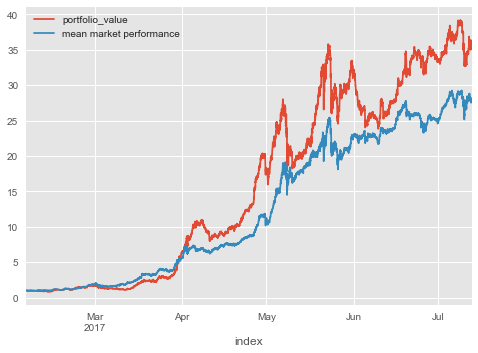

In [28]:
df = pd.DataFrame(env_test.infos)
df.index=df['index']

s=sharpe(df.rate_of_return)
mdd=MDD(df.rate_of_return+1)
mean_market_return=df.mean_market_returns.cumprod().iloc[-1]
print('APV (Accumulated portfolio value): \t{: 2.6f}'.format(df.portfolio_value.iloc[-1]))
print('SR (Sharpe ratio):                 \t{: 2.6f}'.format( s))
print('MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
print('MDR (mean_market_return):          \t{: 2.6f}'.format( mean_market_return))
print('')

# show one run vs average market performance
df.portfolio_value.plot()
df.mean_market_returns.cumprod().plot(label='mean market performance')
plt.legend()